In [1]:
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
shap.initjs()

import re
import ipywidgets as widgets

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold
)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, classification_report, roc_auc_score
import sklearn.metrics.cluster as smc
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
# HELPER

SEED = 66
random.seed(SEED)

from IPython.display import display, HTML
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="Yes")

In [2]:
df = pd.read_csv("./datasets/phish_data.csv")

In [3]:
df.head(50)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [4]:
from urllib.parse import urlparse
import re

In [5]:
pip install tldextract

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import tldextract

In [ ]:
with open("./datasets/top-1m.csv") as f:
    top_domains = set(line.strip().split(",")[1].lower() for line in f)


AttributeError: 'set' object has no attribute 'head'

In [8]:
from urllib.parse import urlparse
schemes = set()

for url in df["url"]:
    schemes.add(urlparse(url).scheme)

print(sorted(schemes))


['', 'activation-pp.3utilities.com', 'aif.adfa.edu.au', 'b.oscars.org', 'cgh.iuadsh.com', 'clouddoll.com', 'coweb.cc.gatech.edu', 'crib.lehn.org', 'cullenprogramming.homelinux.com', 'dbpedia.openlinksw.com', 'dbpubs.stanford.edu', 'deforestkelley.com', 'digitool.amherst.edu', 'digitool.library.mcgill.ca', 'eagle.cch.kcl.ac.uk', 'escuelanet.com', 'express-american.gets-it.net', 'express-american.is-by.us', 'facebooko.tzo.org', 'fletchergeek.homelinux.net', 'ftp', 'gopher.quux.org', 'gpl.eastern.k12.in.us', 'gwj194.internetdsl.tpnet.pl', 'harrison.softwaresystems.com', 'hawkwind.cs.toronto.edu', 'host-174-45-249-138.bln-mt.client.bresnan.net', 'http', 'https', 'icscardnl.endofinternet.net', 'icscardnl.istmein.de', 'ilpubs.stanford.edu', 'images.mechtronix.ca', 'ir.whu.edu.cn', 'john.ccac.rwth-aachen.de', 'larch-www.lcs.mit.edu', 'library.kiwix.org', 'lordoftherings.kevnet.com', 'mail3.virtualsistemas.com.br', 'mit.edu', 'naseba.website.staging.omniaconnect.net', 'ntl208h101-125-245.nt.ne

In [9]:
print(df["url"].head())

0                                     br-icloud.com.br
1                  mp3raid.com/music/krizz_kaliko.html
2                      bopsecrets.org/rexroth/cr/1.htm
3    http://www.garage-pirenne.be/index.php?option=...
4    http://adventure-nicaragua.net/index.php?optio...
Name: url, dtype: object


In [10]:
def add_scheme(url):
    if pd.isna(url):
        return None

    parsed = urlparse(url)

    if not parsed.scheme or not parsed.netloc:
        parsed = urlparse('http://' + url)

    return parsed

In [11]:
from urllib.parse import ParseResult
import re

def fix_ipv6_url(parsed):
    netloc = parsed.netloc

    if '@' in netloc:
        userinfo, hostport = netloc.rsplit('@', 1)
    else:
        userinfo, hostport = '', netloc

    if hostport.startswith('[') and ']' in hostport:
        return parsed
    
    ipv6_no_bracket_pattern = r'^([0-9a-fA-F:]+)(:\d+)?$'

    if re.match(ipv6_no_bracket_pattern, hostport) and not (hostport.startswith('[') and ']' in hostport):
        if ':' in hostport:
            host, port = hostport.rsplit(':', 1)
            if port.isdigit():
                hostport = f"[{host}]:{port}"
            else:
                hostport = f"[{hostport}]"
        else:
            hostport = f"[{hostport}]"
 

    new_netloc = f"{userinfo}@{hostport}" if userinfo else hostport

    return parsed._replace(netloc=new_netloc)

In [12]:
# Test fix_ipv6_url function

url = "2001:db8::1:8080/test"
parsed = add_scheme(url)
fixed = fix_ipv6_url(parsed)
print(fixed.geturl())

http://[2001:db8::1]:8080/test


In [13]:
suspicious_keywords = set(["login", "secure", "verify", "update","confirm", "free", "win", "password", "account", "bank", "ebay", "ebayisapi", "paypal", "signin", "validate", "support", "admin"])

In [14]:
suspicious_tlds = set(["zip", "cricket", "link", "work", "download", "party", "gq", "ml", "cf", "tk", "cn", "ru", "xyz", "top", "info", "biz", "men", "loan", "click", "date"])

In [15]:
import ipaddress

def is_ip_address(hostname):
    try:
        ipaddress.ip_address(hostname)
        return True
    except ValueError:
        return False

In [16]:
executable_exts = set([".exe", ".msi", ".bat", ".cmd", ".scr", ".pif", ".jar", ".wsf", ".vbs", ".js", ".jse", ".ps1", ".sh", ".gadget", ".reg", ".dll", ".drv", ".sys", ".zip", ".rar", ".7z", ".tar", ".gz", ".bz2", ".xz", ".iso", ".img"])

In [17]:
def is_valid_url(url):
    if not isinstance(url, str) or not url.strip():
        return False
    
    if '.' not in url or '/' not in url:
        return False
    
    return True

In [18]:
def safe_parse_url(url):
    try:
        if not is_valid_url(url):
            return None
        
        parsed = add_scheme(url)
        parsed = fix_ipv6_url(parsed)

        return parsed
    
    except Exception as e:
        print(f"Error parsing URL {repr(url)}: {e}")
        return None

In [19]:
def parse_url(url):
    url = url.strip()
    parsed = safe_parse_url(url)
    
    if parsed is None:
        return {
            "url_length": 0,
            "hostname_length": 0,
            "num_dots": 0,
            "num_hyphens": 0,
            "num_digits": 0,
            "num_subdomains": 0,
            "path_depth": 0,
            "path_length": 0,
            "has_suspicious_keywords": 0,
            "has_suspicious_tlds": 0,
            "common_domain": 0,
            "has_ip": 0,
            "has_executable_ext": 0,
            "has_double_extension": 0,
            "has_query": 0
        }
    


    hostname = (parsed.hostname or "").lower()
    parts = hostname.split('.') if hostname else  []
    tld = parts[-1] if parts else ""
    path = parsed.path.lower()

    features = {
        "url_length": len(url),
        "hostname_length": len(hostname),
        "num_dots": hostname.count('.'),
        "num_hyphens": hostname.count('-'),
        "num_digits": sum(c.isdigit() for c in hostname),
        "num_subdomains": hostname.count(".") - 1 if hostname else 0,
        "path_depth": path.rstrip('/').count('/'),
        "path_length": len(path),

        "has_suspicious_keywords": int(any(sus_key in hostname for sus_key in suspicious_keywords)),
        "has_suspicious_tlds": int(tld in suspicious_tlds),
        "common_domain": 1 if hostname in top_domains else 0,
        "has_ip": int(is_ip_address(hostname)),
        
        "has_executable_ext": int(any(path.endswith(ext) for ext in executable_exts)),
        "has_double_extension": int(path.count('.') >= 2 and (any(path.endswith(ext) for ext in executable_exts))),
        "has_query": int(bool(parsed.query))
    }

    return features

In [20]:
features_df = df["url"].apply(parse_url).apply(pd.Series)

Error parsing URL 'Ó\x976¸RTÃ\x06u\x0f\x8b~æ\x82\x0cÙ\x1dg\x810>\x96÷mÖi\x12Ó=;\x9fXZ\\%êýÜ\x05Éfn&\x87\\°%7õÉ"ieÖ\x0f\x161ÄÁêFÐò\x17<\x18\x80$cï\x876t[\x910ò\x9f2\x9e"\x83/Æa^2\x92â\x1fpù/ýãÇ$E¬R«È²ú\x06[Ì¶\x89p\x1f¥qÒ°i°^ò[»³»]±9êdÓS¿\x95Ë\x8a]ùþ5j¿»\x08·ªoc\x9cÂplà7Ê\x0bÏJ§¢#\x823\x1bðDCD\x12\x02õ²çÇ\x17GÝ.Vò=¿QB§Ä\'`Êá\x85ZÉê Ô\x10îÆm\x9e®ÍÝQÓ(z;¹\x1b\x8fÁ\x99\x03\x96ê¬\x9aâyt\x1bÖ\x07\x96Ù®ë\x9e\x84N\x94\x93P\x8f²ÜE\x8eQ': Invalid IPv6 URL
Error parsing URL '¨R\x98ÊÃ\x86ûaCóÞit×ßÂe-DÖ\x8bØ+9YèÌçÏ\x97¯·\x04"0£ÙÕ.0ößF«7¹N\x89R\x1c\x04Ù{ccÉÄãéçx[Ä6a\x1a5Ñ³LÖíÜÉÀ£\x9dÒma¥yRX\x03\x9a*0ÅÝ7×Ê\x83ÁÌ\x05\x05o«Õs¶\x8d0k\x90dèÑ&\x83\x1cÄ\x10"Ï¨mZ\'àD\x8fM×ñ\x01XÚÒK"päî±h¬\x83cAÊeK@4r"^\'ÓFþ1*Ë\x8e\x1d\x8dË PÞô;õ\x9c$úàÑ@\x87þ=êWÑ"Ãhñ\x05\x18®ç^\x18\x11«Ýó^ç\x1a\x1fRú\x8eUJ\x14.<6C\x19\x94y\x1a\x9fÜ\x94FØrÿV2ôæý\x89\x03Zãii\x16\x93I\x0e\x8ab;\x13\x16¨Ë\x97\x9cµu^Í\x99V\x90y)\x9d\xadè»âýº\x01+\x9f\x94S\x99Ö\x1e\x17á\x10\x95\x03Ãì?\x1få6åÔ/': Invalid IPv6 URL
Error parsing URL '1]Î¼0#W»æ½Î4>¥õ\

In [21]:
features_df.head(30)

,url_length,hostname_length,num_dots,num_hyphens,num_digits,num_subdomains,path_depth,path_length,has_suspicious_keywords,has_suspicious_tlds,common_domain,has_ip,has_executable_ext,has_double_extension,has_query
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,35,11,1,0,1,0,2,24,0,0,0,0,0,0,0
2,31,14,1,0,0,0,3,17,0,0,0,0,0,0,0
3,88,21,2,1,0,1,1,10,0,0,0,0,0,0,1
4,235,23,1,1,0,0,1,10,0,0,0,0,0,0,1
5,118,11,1,0,0,0,3,100,0,0,0,0,0,0,0
6,45,11,2,0,0,1,6,34,0,0,1,0,0,0,0
7,46,18,1,0,0,0,0,1,0,0,1,0,0,0,1
8,44,22,2,0,0,1,1,15,0,0,0,0,0,0,0
9,45,12,1,0,0,0,2,33,0,0,1,0,0,0,0


In [22]:
df.head(30)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [23]:
print([d for d in top_domains if d.startswith("en.wikipedia")])

['en.wikipedia-on-ipfs.org', 'en.wikipedia.org']


In [24]:
print(df["url"].head(30).tolist()) 

['br-icloud.com.br', 'mp3raid.com/music/krizz_kaliko.html', 'bopsecrets.org/rexroth/cr/1.htm', 'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15', 'http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0', 'http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html', 'espn.go.com/nba/player/_/id/3457/brandon-rush', 'yourbittorrent.com/?q=anthony-hamilton-soulife', 'http://www.pashminaonline.com/pure-pashminas', 'allmusic.com/album/crazy-from-the-heat-r16990', 'corporationwiki.com/Ohio/Columbus/frank-s-benson-P3333917.aspx', 'http://www.ikenmijnkunst.nl/index.php/exposities/exposities-2006', 'myspace.com/video/vid/30602581', 'http://www.lebensmittel-ueberwachung.de/index.php/aktuelles.1', 'http://www.szabadmunka

In [25]:
combined_df = pd.concat([df, features_df], axis=1)

In [26]:
combined_df.head(30)

,url,type,url_length,hostname_length,num_dots,num_hyphens,num_digits,num_subdomains,path_depth,path_length,has_suspicious_keywords,has_suspicious_tlds,common_domain,has_ip,has_executable_ext,has_double_extension,has_query
0,br-icloud.com.br,phishing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,11,1,0,1,0,2,24,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,14,1,0,0,0,3,17,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,21,2,1,0,1,1,10,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,23,1,1,0,0,1,10,0,0,0,0,0,0,1
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,118,11,1,0,0,0,3,100,0,0,0,0,0,0,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,45,11,2,0,0,1,6,34,0,0,1,0,0,0,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,46,18,1,0,0,0,0,1,0,0,1,0,0,0,1
8,http://www.pashminaonline.com/pure-pashminas,defacement,44,22,2,0,0,1,1,15,0,0,0,0,0,0,0
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,45,12,1,0,0,0,2,33,0,0,1,0,0,0,0


In [27]:
# Step 1: Find the row(s) containing wikipedia
wikipedia_rows = df[df["url"].str.contains("wikipedia", case=False, na=False)]
print(wikipedia_rows)

                                                      url      type
29                     en.wikipedia.org/wiki/North_Dakota    benign
97                      en.wikipedia.org/wiki/Lloyd_Bacon    benign
123       en.wikipedia.org/wiki/Blessed_by_a_Broken_Heart    benign
154                     en.wikipedia.org/wiki/Neil_Curtis    benign
177                    en.wikipedia.org/wiki/Kenji_Nojima    benign
...                                                   ...       ...
650807         en.wikipedia.org/wiki/Lost:_The_Video_Game  phishing
650824  'en.wikipedia.org/wiki/Marc_Ecko\'s_Getting_Up...  phishing
650896  en.wikipedia.org/wiki/No_More_Heroes_(video_game)  phishing
651157  en.wikipedia.org/wiki/Call_of_Cthulhu:_Dark_Co...  phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)  phishing

[13687 rows x 2 columns]


In [28]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   url                      651191 non-null  object
 1   type                     651191 non-null  object
 2   url_length               651191 non-null  int64 
 3   hostname_length          651191 non-null  int64 
 4   num_dots                 651191 non-null  int64 
 5   num_hyphens              651191 non-null  int64 
 6   num_digits               651191 non-null  int64 
 7   num_subdomains           651191 non-null  int64 
 8   path_depth               651191 non-null  int64 
 9   path_length              651191 non-null  int64 
 10  has_suspicious_keywords  651191 non-null  int64 
 11  has_suspicious_tlds      651191 non-null  int64 
 12  common_domain            651191 non-null  int64 
 13  has_ip                   651191 non-null  int64 
 14  has_executable_ext  

In [29]:
combined_df.isnull().sum()

url                        0
type                       0
url_length                 0
hostname_length            0
num_dots                   0
num_hyphens                0
num_digits                 0
num_subdomains             0
path_depth                 0
path_length                0
has_suspicious_keywords    0
has_suspicious_tlds        0
common_domain              0
has_ip                     0
has_executable_ext         0
has_double_extension       0
has_query                  0
dtype: int64

In [30]:
combined_df = combined_df.drop(["url"], axis=1)

le = LabelEncoder()
combined_df["target"] = le.fit_transform(combined_df["type"])
combined_df = combined_df.drop(["type"], axis=1)

print(le.classes_)

y = combined_df["target"]
x = combined_df.drop(["target"], axis=1)

train_raw, test_raw, target, target_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)



['benign' 'defacement' 'malware' 'phishing']


In [31]:
numerical_features = list(train_raw)

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("minimax", MinMaxScaler())  # not necessary, but safe
])

full_pipeline = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_features)
    ]
)



train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

features_names = full_pipeline.get_feature_names_out(list(x.columns))

In [32]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   url_length               651191 non-null  int64
 1   hostname_length          651191 non-null  int64
 2   num_dots                 651191 non-null  int64
 3   num_hyphens              651191 non-null  int64
 4   num_digits               651191 non-null  int64
 5   num_subdomains           651191 non-null  int64
 6   path_depth               651191 non-null  int64
 7   path_length              651191 non-null  int64
 8   has_suspicious_keywords  651191 non-null  int64
 9   has_suspicious_tlds      651191 non-null  int64
 10  common_domain            651191 non-null  int64
 11  has_ip                   651191 non-null  int64
 12  has_executable_ext       651191 non-null  int64
 13  has_double_extension     651191 non-null  int64
 14  has_query                651191 non-

In [33]:
combined_df.columns

Index(['url_length', 'hostname_length', 'num_dots', 'num_hyphens',
       'num_digits', 'num_subdomains', 'path_depth', 'path_length',
       'has_suspicious_keywords', 'has_suspicious_tlds', 'common_domain',
       'has_ip', 'has_executable_ext', 'has_double_extension', 'has_query',
       'target'],
      dtype='object')

In [34]:
y.value_counts()

target
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64

In [ ]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    n_jobs=-1,
    tree_method="hist",
    random_state=0
)

In [38]:
xgb_model.fit(train, target)
test_prediction = xgb_model.predict(test)

In [39]:
print(f"Accuracy: {accuracy_score(target_test, test_prediction)}")

Accuracy: 0.9284238976036364


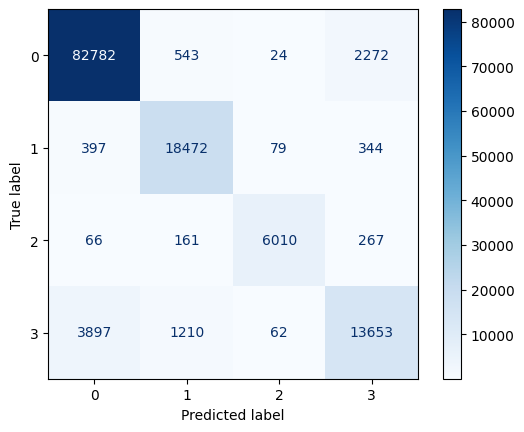

In [40]:
cm = confusion_matrix(target_test, test_prediction)
disp_cm = ConfusionMatrixDisplay(cm)
disp_cm.plot(cmap="Blues")

In [41]:
print(classification_report(target_test, test_prediction, target_names=le.classes_))

              precision    recall  f1-score   support

      benign       0.95      0.97      0.96     85621
  defacement       0.91      0.96      0.93     19292
     malware       0.97      0.92      0.95      6504
    phishing       0.83      0.73      0.77     18822

    accuracy                           0.93    130239
   macro avg       0.91      0.89      0.90    130239
weighted avg       0.93      0.93      0.93    130239



In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
prob = xgb_model.predict_proba(test)
auc = roc_auc_score(target_test, prob, multi_class="ovr")
print("ROC AUC:", auc)

ROC AUC: 0.9865090066494273


In [44]:
from sklearn.preprocessing import label_binarize

true_bin = label_binarize(target_test, classes=[0, 1, 2, 3])

auc_scores = {}
for i, classname in enumerate(le.classes_):
    auc = roc_auc_score(true_bin[:, i], prob[:, i])
    auc_scores[classname] = auc


print("AUC Per-Class:")
for cls, auc in auc_scores.items():
    print(f"{cls}: {auc:.3f}")


macro_auc = np.mean(list(auc_scores.values()))
print(f"\nMACRO AVERAGE: {macro_auc:.3f}")

AUC Per-Class:
benign: 0.986
defacement: 0.996
malware: 0.997
phishing: 0.966

MACRO AVERAGE: 0.987


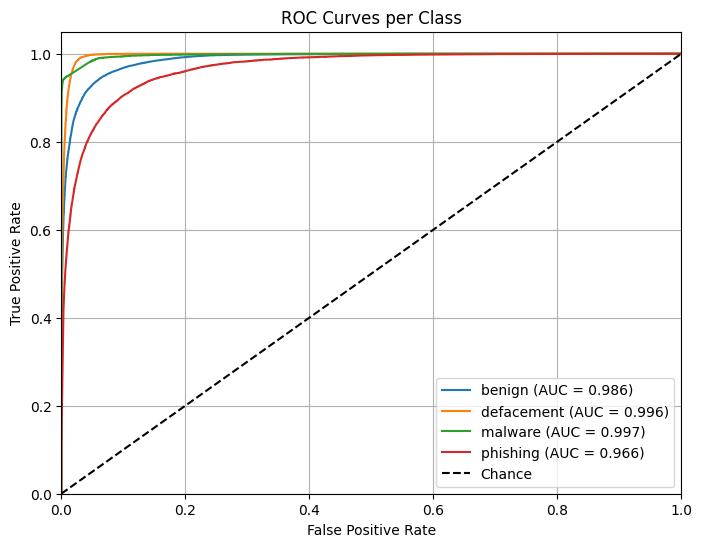

In [45]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}

for i, classname in enumerate(le.classes_):
    fpr[i], tpr[i], _ = roc_curve(true_bin[:, i], prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i, classname in enumerate(le.classes_):
    plt.plot(fpr[i], tpr[i], label=f"{classname} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [46]:
param_grid = {
    "n_estimators": [500, 1000],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc_ovr',
    cv=3,
    n_jobs=-1,
    verbose=2,
    refit=True,
    return_train_score=True
)

grid.fit(train, target)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=8,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [4, 6, 8],
                         'n_estimators': [500, 1000]},
             return_train_score=True, scoring='roc_auc_ovr', verbose=2)

In [47]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Score (ROC_AUC_OVR): {grid.best_score_}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}
Best Score (ROC_AUC_OVR): 0.985483216485485


In [48]:
import joblib

joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']